In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import time

In [3]:
class StanfordDragonDataset(Dataset):

    def __init__(self, root_dir="./dataset"):
        self.root_dir = root_dir
        self.poses = torch.from_numpy(np.load(root_dir + "/poses.npy"))
        self.focal = 220.836477965
    
    def __len__(self):
        filenames = [f for f in os.listdir(self.root_dir) if (f[-3:] in ["jpg", "png"])]
        return len(filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()[0]
        img_path = self.root_dir + "/gt-%d.png" % (idx % self.__len__())
        image = Image.open(img_path) # (h, w, ch)
        image = torch.from_numpy(np.array(image)) / (256.0 - 1.0)
        pose = self.poses[idx]
        focal = self.focal
        return [image[:,:,:-1], pose, focal]

In [4]:
class NeRF(nn.Module):

    def __init__(self, device, min_bounds, max_bounds, num_enc_p=10, num_enc_d=4, num_channels=256):
        super(NeRF, self).__init__()
        self.device = device
        self.num_enc_p = num_enc_p
        self.num_enc_d = num_enc_d
        self.num_channels = num_channels
        self.min_bounds = min_bounds
        self.max_bounds = max_bounds
        self.layers = nn.ModuleList([
            self.layer(6 * num_enc_p, num_channels),
            self.layer(num_channels, num_channels),
            self.layer(num_channels, num_channels),
            self.layer(num_channels, num_channels),
            self.layer(num_channels, num_channels),
            self.layer(6 * num_enc_p + num_channels, num_channels),
            self.layer(num_channels, num_channels),
            self.layer(num_channels, num_channels),
            self.layer(num_channels, num_channels + 1, act_fn = torch.nn.Identity),
            self.layer(6 * num_enc_d + num_channels, num_channels // 2),
            self.layer(num_channels // 2, 3, act_fn = torch.nn.Sigmoid)
        ])
    
    def layer(self, in_features, out_features, act_fn = torch.nn.ReLU):
        return nn.Sequential(
            torch.nn.Linear(in_features, out_features),
            act_fn()
        )

    def get_rays(self, image, camera_pose, focal):
        W = image.shape[1]
        H = image.shape[0]
        i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))
        lat = (i - W/2) / W
        lon = (j - H/2) / H
        dirs = torch.stack([(i - (W - 1) * 0.5) / focal, -(j - (H - 1) * 0.5) / focal, -torch.ones_like(i)], -1)
        rays_d = torch.sum(dirs[..., np.newaxis, :] * camera_pose[:3,:3], -1)
        rays_d = rays_d.permute((1, 0, 2)) # (w, h, ch) -> (h, w, ch)
        rays_d = torch.reshape(rays_d, [-1,3])
        rays_d = rays_d / torch.sqrt(torch.sum(torch.square(rays_d), dim=1))[:,None]
        rays_o = camera_pose[:3,-1].expand(rays_d.shape)
        gt_colors = image.reshape([-1, 3])
        return [rays_o, rays_d, gt_colors]

    def box_intersection(self, positions, directions): 
        inv_directions = 1 / directions
        t0 = (self.min_bounds - positions) * inv_directions
        t1 = (self.max_bounds - positions) * inv_directions
        tmax, _ = torch.min(torch.max(t0, t1), dim=1)
        return tmax
    
    def render_rays(self, positions, directions, num_samples, noise=True):
        batch_size = positions.shape[0]
        path_length = self.box_intersection(positions, directions)
        samples = torch.arange(1, num_samples + 1).to(device) / num_samples
        p = positions[:,None,:] + directions[:,None,:] * samples[None,:,None] * path_length[:,None,None]
        p_flat = torch.reshape(p, (-1, 3)).float()
        d = directions.expand((num_samples, batch_size, 3)).permute((1, 0, 2))
        d_flat = torch.reshape(d, (-1, 3)).float()
        colors, densities = self.forward(p_flat, d_flat)
        colors = colors.reshape((batch_size, num_samples, 3))
        densities = densities.reshape(d.shape[:-1])
        delta = path_length / num_samples
        batch_ones = torch.ones((batch_size, 1)).to(device)
        alpha = 1.0 - torch.exp(-1.0 * densities * delta[:,None])          
        T = torch.cumprod(torch.cat([batch_ones, 1.0 - alpha], -1), -1)[:, :-1]
        weights = T * alpha
        projected_colors = torch.sum(weights[:,:,None] * colors, dim=1)
        depth = torch.sum(weights * samples, dim=1) 
        return [projected_colors, depth, weights]
            
    def encode(self, x, L):
        batch_size = x.shape[0]
        f = ((2.0 ** torch.arange(0, L))).to(device)
        f = f.expand((batch_size, 3, L))
        f = torch.cat([torch.cos(math.pi * f * x[:,:,None]), torch.sin(math.pi * f * x[:,:,None])], dim=2)
        return f.reshape((batch_size, -1))

    def forward(self, p, d):
        p_normalized = -1. + 2. * (p - self.min_bounds) / (self.max_bounds - self.min_bounds)
        p_enc = self.encode(p_normalized, self.num_enc_p);
        d_enc = self.encode(d, self.num_enc_d);
        res1 = self.layers[0](p_enc)
        res2 = self.layers[1](res1)
        res3 = self.layers[2](res2)
        res4 = self.layers[3](res3)
        res5 = self.layers[4](res4)
        res6 = self.layers[5](torch.cat([p_enc, res5], dim=1))
        res7 = self.layers[6](res6)
        res8 = self.layers[7](res7)
        res9 = self.layers[8](res8)
        density = F.relu(res9[:,0])
        res10 = self.layers[9](torch.cat([res9[:,1:], d_enc], dim=1))
        color = self.layers[10](res10)
        return [color, density]

Total model parameters: 593924
Total images: 400


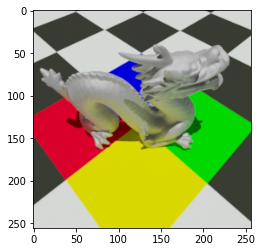

In [5]:
# Instantiate dataset & model 
dataset = StanfordDragonDataset()
cuda = True
device = torch.device("cuda") if (cuda) else torch.device("cpu")
min_bounds = torch.Tensor([-10,-10,-10]).to(device)
max_bounds = torch.Tensor([10, 10, 10]).to(device)
model = NeRF(device, min_bounds, max_bounds)
if (cuda): model.cuda()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total model parameters: %d" % total_params)
print("Total images: %d" % len(dataset))

In [7]:
# Training variables
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
iterations = 1000
rays_per_batch = 2**11
num_samples = 256
all_positions = []
all_directions = []
all_gt_colors = []

# Gather all rays
for i in range(len(dataset)):
    image, pose, focal = dataset[i]
    positions, directions, gt_colors = model.get_rays(image, pose, focal)
    all_positions.append(positions)
    all_directions.append(directions)
    all_gt_colors.append(gt_colors)

# Concatenate all rays
all_positions = torch.cat(all_positions, dim=0)
all_directions = torch.cat(all_directions, dim=0)
all_gt_colors = torch.cat(all_gt_colors, dim=0)

# Shuffle rays
shuffle = torch.randperm(all_positions.shape[0])
all_positions = all_positions[shuffle]
all_directions = all_directions[shuffle]
all_gt_colors = all_gt_colors[shuffle]

rays_per_iteration = all_positions.shape[0]

In [7]:
# Training loop
for i in range(iterations):
    current_idx = 0
    losses = []
    while(current_idx < rays_per_iteration):
        optimizer.zero_grad()
        indices = torch.arange(current_idx, min(all_positions.shape[0], current_idx + rays_per_batch))
        positions = all_positions[indices].to(device)
        directions = all_directions[indices].to(device)
        colors, depths, weights = model.render_rays(positions, directions, num_samples)
        gt = all_gt_colors[indices].to(device)
        loss = torch.mean(torch.square(colors - gt))
        loss.backward()
        current_idx += rays_per_batch
        optimizer.step()
        print('iteration: %d, loss: %.4f, ray count: %.2f%%' % (i, loss.item(), 100 * current_idx / rays_per_iteration))
    torch.save(model.state_dict(), "model-%d.pth" % i)    

iteration: 0, loss: 0.3361, entropy: 1.5400, ray count: 0.01%
iteration: 0, loss: 0.3420, entropy: 5.5452, ray count: 0.02%
iteration: 0, loss: 0.3460, entropy: 5.5452, ray count: 0.02%
iteration: 0, loss: 0.3438, entropy: 5.5452, ray count: 0.03%
iteration: 0, loss: 0.3450, entropy: 5.5452, ray count: 0.04%
iteration: 0, loss: 0.3432, entropy: 5.5452, ray count: 0.05%
iteration: 0, loss: 0.3461, entropy: 5.5452, ray count: 0.05%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 0.06%
iteration: 0, loss: 0.3450, entropy: 5.5452, ray count: 0.07%
iteration: 0, loss: 0.3533, entropy: 5.5452, ray count: 0.08%
iteration: 0, loss: 0.3460, entropy: 5.5452, ray count: 0.09%
iteration: 0, loss: 0.3398, entropy: 5.5452, ray count: 0.09%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 0.10%
iteration: 0, loss: 0.3396, entropy: 5.5452, ray count: 0.11%
iteration: 0, loss: 0.3469, entropy: 5.5452, ray count: 0.12%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 0.12%
iteratio

iteration: 0, loss: 0.3433, entropy: 5.5452, ray count: 1.05%
iteration: 0, loss: 0.3482, entropy: 5.5452, ray count: 1.05%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 1.06%
iteration: 0, loss: 0.3462, entropy: 5.5452, ray count: 1.07%
iteration: 0, loss: 0.3373, entropy: 5.5452, ray count: 1.08%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 1.09%
iteration: 0, loss: 0.3370, entropy: 5.5452, ray count: 1.09%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 1.10%
iteration: 0, loss: 0.3466, entropy: 5.5452, ray count: 1.11%
iteration: 0, loss: 0.3444, entropy: 5.5452, ray count: 1.12%
iteration: 0, loss: 0.3352, entropy: 5.5452, ray count: 1.12%
iteration: 0, loss: 0.3439, entropy: 5.5452, ray count: 1.13%
iteration: 0, loss: 0.3373, entropy: 5.5452, ray count: 1.14%
iteration: 0, loss: 0.3443, entropy: 5.5452, ray count: 1.15%
iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 1.16%
iteration: 0, loss: 0.3381, entropy: 5.5452, ray count: 1.16%
iteratio

iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 2.09%
iteration: 0, loss: 0.3363, entropy: 5.5452, ray count: 2.09%
iteration: 0, loss: 0.3299, entropy: 5.5452, ray count: 2.10%
iteration: 0, loss: 0.3384, entropy: 5.5452, ray count: 2.11%
iteration: 0, loss: 0.3407, entropy: 5.5452, ray count: 2.12%
iteration: 0, loss: 0.3374, entropy: 5.5452, ray count: 2.12%
iteration: 0, loss: 0.3376, entropy: 5.5452, ray count: 2.13%
iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 2.14%
iteration: 0, loss: 0.3448, entropy: 5.5452, ray count: 2.15%
iteration: 0, loss: 0.3402, entropy: 5.5452, ray count: 2.16%
iteration: 0, loss: 0.3439, entropy: 5.5452, ray count: 2.16%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 2.17%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 2.18%
iteration: 0, loss: 0.3353, entropy: 5.5452, ray count: 2.19%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 2.20%
iteration: 0, loss: 0.3404, entropy: 5.5452, ray count: 2.20%
iteratio

iteration: 0, loss: 0.3402, entropy: 5.5452, ray count: 3.12%
iteration: 0, loss: 0.3414, entropy: 5.5452, ray count: 3.13%
iteration: 0, loss: 0.3390, entropy: 5.5452, ray count: 3.14%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 3.15%
iteration: 0, loss: 0.3381, entropy: 5.5452, ray count: 3.16%
iteration: 0, loss: 0.3479, entropy: 5.5452, ray count: 3.16%
iteration: 0, loss: 0.3368, entropy: 5.5452, ray count: 3.17%
iteration: 0, loss: 0.3384, entropy: 5.5452, ray count: 3.18%
iteration: 0, loss: 0.3417, entropy: 5.5452, ray count: 3.19%
iteration: 0, loss: 0.3414, entropy: 5.5452, ray count: 3.20%
iteration: 0, loss: 0.3397, entropy: 5.5452, ray count: 3.20%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 3.21%
iteration: 0, loss: 0.3416, entropy: 5.5452, ray count: 3.22%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 3.23%
iteration: 0, loss: 0.3467, entropy: 5.5452, ray count: 3.23%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 3.24%
iteratio

iteration: 0, loss: 0.3488, entropy: 5.5452, ray count: 4.16%
iteration: 0, loss: 0.3333, entropy: 5.5452, ray count: 4.17%
iteration: 0, loss: 0.3375, entropy: 5.5452, ray count: 4.18%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 4.19%
iteration: 0, loss: 0.3341, entropy: 5.5452, ray count: 4.20%
iteration: 0, loss: 0.3323, entropy: 5.5452, ray count: 4.20%
iteration: 0, loss: 0.3401, entropy: 5.5452, ray count: 4.21%
iteration: 0, loss: 0.3420, entropy: 5.5452, ray count: 4.22%
iteration: 0, loss: 0.3452, entropy: 5.5452, ray count: 4.23%
iteration: 0, loss: 0.3384, entropy: 5.5452, ray count: 4.23%
iteration: 0, loss: 0.3463, entropy: 5.5452, ray count: 4.24%
iteration: 0, loss: 0.3361, entropy: 5.5452, ray count: 4.25%
iteration: 0, loss: 0.3362, entropy: 5.5452, ray count: 4.26%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 4.27%
iteration: 0, loss: 0.3391, entropy: 5.5452, ray count: 4.27%
iteration: 0, loss: 0.3330, entropy: 5.5452, ray count: 4.28%
iteratio

iteration: 0, loss: 0.3407, entropy: 5.5452, ray count: 5.20%
iteration: 0, loss: 0.3425, entropy: 5.5452, ray count: 5.21%
iteration: 0, loss: 0.3463, entropy: 5.5452, ray count: 5.22%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 5.23%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 5.23%
iteration: 0, loss: 0.3364, entropy: 5.5452, ray count: 5.24%
iteration: 0, loss: 0.3424, entropy: 5.5452, ray count: 5.25%
iteration: 0, loss: 0.3385, entropy: 5.5452, ray count: 5.26%
iteration: 0, loss: 0.3433, entropy: 5.5452, ray count: 5.27%
iteration: 0, loss: 0.3418, entropy: 5.5452, ray count: 5.27%
iteration: 0, loss: 0.3369, entropy: 5.5452, ray count: 5.28%
iteration: 0, loss: 0.3471, entropy: 5.5452, ray count: 5.29%
iteration: 0, loss: 0.3346, entropy: 5.5452, ray count: 5.30%
iteration: 0, loss: 0.3393, entropy: 5.5452, ray count: 5.30%
iteration: 0, loss: 0.3419, entropy: 5.5452, ray count: 5.31%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 5.32%
iteratio

iteration: 0, loss: 0.3331, entropy: 5.5452, ray count: 6.24%
iteration: 0, loss: 0.3425, entropy: 5.5452, ray count: 6.25%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 6.26%
iteration: 0, loss: 0.3360, entropy: 5.5452, ray count: 6.27%
iteration: 0, loss: 0.3562, entropy: 5.5452, ray count: 6.27%
iteration: 0, loss: 0.3404, entropy: 5.5452, ray count: 6.28%
iteration: 0, loss: 0.3414, entropy: 5.5452, ray count: 6.29%
iteration: 0, loss: 0.3419, entropy: 5.5452, ray count: 6.30%
iteration: 0, loss: 0.3408, entropy: 5.5452, ray count: 6.30%
iteration: 0, loss: 0.3396, entropy: 5.5452, ray count: 6.31%
iteration: 0, loss: 0.3369, entropy: 5.5452, ray count: 6.32%
iteration: 0, loss: 0.3485, entropy: 5.5452, ray count: 6.33%
iteration: 0, loss: 0.3331, entropy: 5.5452, ray count: 6.34%
iteration: 0, loss: 0.3362, entropy: 5.5452, ray count: 6.34%
iteration: 0, loss: 0.3353, entropy: 5.5452, ray count: 6.35%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 6.36%
iteratio

iteration: 0, loss: 0.3422, entropy: 5.5452, ray count: 7.28%
iteration: 0, loss: 0.3398, entropy: 5.5452, ray count: 7.29%
iteration: 0, loss: 0.3443, entropy: 5.5452, ray count: 7.30%
iteration: 0, loss: 0.3462, entropy: 5.5452, ray count: 7.30%
iteration: 0, loss: 0.3426, entropy: 5.5452, ray count: 7.31%
iteration: 0, loss: 0.3385, entropy: 5.5452, ray count: 7.32%
iteration: 0, loss: 0.3496, entropy: 5.5452, ray count: 7.33%
iteration: 0, loss: 0.3384, entropy: 5.5452, ray count: 7.34%
iteration: 0, loss: 0.3338, entropy: 5.5452, ray count: 7.34%
iteration: 0, loss: 0.3359, entropy: 5.5452, ray count: 7.35%
iteration: 0, loss: 0.3464, entropy: 5.5452, ray count: 7.36%
iteration: 0, loss: 0.3342, entropy: 5.5452, ray count: 7.37%
iteration: 0, loss: 0.3450, entropy: 5.5452, ray count: 7.38%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 7.38%
iteration: 0, loss: 0.3473, entropy: 5.5452, ray count: 7.39%
iteration: 0, loss: 0.3444, entropy: 5.5452, ray count: 7.40%
iteratio

iteration: 0, loss: 0.3444, entropy: 5.5452, ray count: 8.32%
iteration: 0, loss: 0.3376, entropy: 5.5452, ray count: 8.33%
iteration: 0, loss: 0.3430, entropy: 5.5452, ray count: 8.34%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 8.34%
iteration: 0, loss: 0.3456, entropy: 5.5452, ray count: 8.35%
iteration: 0, loss: 0.3438, entropy: 5.5452, ray count: 8.36%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 8.37%
iteration: 0, loss: 0.3487, entropy: 5.5452, ray count: 8.38%
iteration: 0, loss: 0.3404, entropy: 5.5452, ray count: 8.38%
iteration: 0, loss: 0.3380, entropy: 5.5452, ray count: 8.39%
iteration: 0, loss: 0.3351, entropy: 5.5452, ray count: 8.40%
iteration: 0, loss: 0.3434, entropy: 5.5452, ray count: 8.41%
iteration: 0, loss: 0.3450, entropy: 5.5452, ray count: 8.41%
iteration: 0, loss: 0.3458, entropy: 5.5452, ray count: 8.42%
iteration: 0, loss: 0.3429, entropy: 5.5452, ray count: 8.43%
iteration: 0, loss: 0.3440, entropy: 5.5452, ray count: 8.44%
iteratio

iteration: 0, loss: 0.3375, entropy: 5.5452, ray count: 9.36%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 9.37%
iteration: 0, loss: 0.3493, entropy: 5.5452, ray count: 9.38%
iteration: 0, loss: 0.3390, entropy: 5.5452, ray count: 9.38%
iteration: 0, loss: 0.3424, entropy: 5.5452, ray count: 9.39%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 9.40%
iteration: 0, loss: 0.3345, entropy: 5.5452, ray count: 9.41%
iteration: 0, loss: 0.3374, entropy: 5.5452, ray count: 9.41%
iteration: 0, loss: 0.3493, entropy: 5.5452, ray count: 9.42%
iteration: 0, loss: 0.3407, entropy: 5.5452, ray count: 9.43%
iteration: 0, loss: 0.3466, entropy: 5.5452, ray count: 9.44%
iteration: 0, loss: 0.3459, entropy: 5.5452, ray count: 9.45%
iteration: 0, loss: 0.3415, entropy: 5.5452, ray count: 9.45%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 9.46%
iteration: 0, loss: 0.3380, entropy: 5.5452, ray count: 9.47%
iteration: 0, loss: 0.3346, entropy: 5.5452, ray count: 9.48%
iteratio

iteration: 0, loss: 0.3359, entropy: 5.5452, ray count: 10.39%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 10.40%
iteration: 0, loss: 0.3466, entropy: 5.5452, ray count: 10.41%
iteration: 0, loss: 0.3414, entropy: 5.5452, ray count: 10.41%
iteration: 0, loss: 0.3449, entropy: 5.5452, ray count: 10.42%
iteration: 0, loss: 0.3435, entropy: 5.5452, ray count: 10.43%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 10.44%
iteration: 0, loss: 0.3433, entropy: 5.5452, ray count: 10.45%
iteration: 0, loss: 0.3412, entropy: 5.5452, ray count: 10.45%
iteration: 0, loss: 0.3370, entropy: 5.5452, ray count: 10.46%
iteration: 0, loss: 0.3361, entropy: 5.5452, ray count: 10.47%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 10.48%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 10.48%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 10.49%
iteration: 0, loss: 0.3453, entropy: 5.5452, ray count: 10.50%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3398, entropy: 5.5452, ray count: 11.41%
iteration: 0, loss: 0.3511, entropy: 5.5452, ray count: 11.42%
iteration: 0, loss: 0.3381, entropy: 5.5452, ray count: 11.43%
iteration: 0, loss: 0.3435, entropy: 5.5452, ray count: 11.44%
iteration: 0, loss: 0.3392, entropy: 5.5452, ray count: 11.45%
iteration: 0, loss: 0.3471, entropy: 5.5452, ray count: 11.45%
iteration: 0, loss: 0.3425, entropy: 5.5452, ray count: 11.46%
iteration: 0, loss: 0.3433, entropy: 5.5452, ray count: 11.47%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 11.48%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 11.48%
iteration: 0, loss: 0.3418, entropy: 5.5452, ray count: 11.49%
iteration: 0, loss: 0.3427, entropy: 5.5452, ray count: 11.50%
iteration: 0, loss: 0.3339, entropy: 5.5452, ray count: 11.51%
iteration: 0, loss: 0.3473, entropy: 5.5452, ray count: 11.52%
iteration: 0, loss: 0.3483, entropy: 5.5452, ray count: 11.52%
iteration: 0, loss: 0.3432, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 12.44%
iteration: 0, loss: 0.3461, entropy: 5.5452, ray count: 12.45%
iteration: 0, loss: 0.3462, entropy: 5.5452, ray count: 12.45%
iteration: 0, loss: 0.3356, entropy: 5.5452, ray count: 12.46%
iteration: 0, loss: 0.3414, entropy: 5.5452, ray count: 12.47%
iteration: 0, loss: 0.3353, entropy: 5.5452, ray count: 12.48%
iteration: 0, loss: 0.3489, entropy: 5.5452, ray count: 12.48%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 12.49%
iteration: 0, loss: 0.3374, entropy: 5.5452, ray count: 12.50%
iteration: 0, loss: 0.3368, entropy: 5.5452, ray count: 12.51%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 12.52%
iteration: 0, loss: 0.3421, entropy: 5.5452, ray count: 12.52%
iteration: 0, loss: 0.3448, entropy: 5.5452, ray count: 12.53%
iteration: 0, loss: 0.3496, entropy: 5.5452, ray count: 12.54%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 12.55%
iteration: 0, loss: 0.3461, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3396, entropy: 5.5452, ray count: 13.46%
iteration: 0, loss: 0.3457, entropy: 5.5452, ray count: 13.47%
iteration: 0, loss: 0.3457, entropy: 5.5452, ray count: 13.48%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 13.48%
iteration: 0, loss: 0.3388, entropy: 5.5452, ray count: 13.49%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 13.50%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 13.51%
iteration: 0, loss: 0.3454, entropy: 5.5452, ray count: 13.52%
iteration: 0, loss: 0.3342, entropy: 5.5452, ray count: 13.52%
iteration: 0, loss: 0.3455, entropy: 5.5452, ray count: 13.53%
iteration: 0, loss: 0.3354, entropy: 5.5452, ray count: 13.54%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 13.55%
iteration: 0, loss: 0.3431, entropy: 5.5452, ray count: 13.55%
iteration: 0, loss: 0.3423, entropy: 5.5452, ray count: 13.56%
iteration: 0, loss: 0.3310, entropy: 5.5452, ray count: 13.57%
iteration: 0, loss: 0.3416, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 14.48%
iteration: 0, loss: 0.3475, entropy: 5.5452, ray count: 14.49%
iteration: 0, loss: 0.3467, entropy: 5.5452, ray count: 14.50%
iteration: 0, loss: 0.3438, entropy: 5.5452, ray count: 14.51%
iteration: 0, loss: 0.3441, entropy: 5.5452, ray count: 14.52%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 14.52%
iteration: 0, loss: 0.3346, entropy: 5.5452, ray count: 14.53%
iteration: 0, loss: 0.3391, entropy: 5.5452, ray count: 14.54%
iteration: 0, loss: 0.3511, entropy: 5.5452, ray count: 14.55%
iteration: 0, loss: 0.3424, entropy: 5.5452, ray count: 14.55%
iteration: 0, loss: 0.3456, entropy: 5.5452, ray count: 14.56%
iteration: 0, loss: 0.3444, entropy: 5.5452, ray count: 14.57%
iteration: 0, loss: 0.3410, entropy: 5.5452, ray count: 14.58%
iteration: 0, loss: 0.3471, entropy: 5.5452, ray count: 14.59%
iteration: 0, loss: 0.3457, entropy: 5.5452, ray count: 14.59%
iteration: 0, loss: 0.3498, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3367, entropy: 5.5452, ray count: 15.51%
iteration: 0, loss: 0.3362, entropy: 5.5452, ray count: 15.52%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 15.52%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 15.53%
iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 15.54%
iteration: 0, loss: 0.3347, entropy: 5.5452, ray count: 15.55%
iteration: 0, loss: 0.3442, entropy: 5.5452, ray count: 15.55%
iteration: 0, loss: 0.3417, entropy: 5.5452, ray count: 15.56%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 15.57%
iteration: 0, loss: 0.3434, entropy: 5.5452, ray count: 15.58%
iteration: 0, loss: 0.3350, entropy: 5.5452, ray count: 15.59%
iteration: 0, loss: 0.3474, entropy: 5.5452, ray count: 15.59%
iteration: 0, loss: 0.3421, entropy: 5.5452, ray count: 15.60%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 15.61%
iteration: 0, loss: 0.3531, entropy: 5.5452, ray count: 15.62%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 16.53%
iteration: 0, loss: 0.3467, entropy: 5.5452, ray count: 16.54%
iteration: 0, loss: 0.3421, entropy: 5.5452, ray count: 16.55%
iteration: 0, loss: 0.3423, entropy: 5.5452, ray count: 16.55%
iteration: 0, loss: 0.3351, entropy: 5.5452, ray count: 16.56%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 16.57%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 16.58%
iteration: 0, loss: 0.3378, entropy: 5.5452, ray count: 16.59%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 16.59%
iteration: 0, loss: 0.3412, entropy: 5.5452, ray count: 16.60%
iteration: 0, loss: 0.3492, entropy: 5.5452, ray count: 16.61%
iteration: 0, loss: 0.3517, entropy: 5.5452, ray count: 16.62%
iteration: 0, loss: 0.3312, entropy: 5.5452, ray count: 16.62%
iteration: 0, loss: 0.3419, entropy: 5.5452, ray count: 16.63%
iteration: 0, loss: 0.3449, entropy: 5.5452, ray count: 16.64%
iteration: 0, loss: 0.3431, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3394, entropy: 5.5452, ray count: 17.55%
iteration: 0, loss: 0.3335, entropy: 5.5452, ray count: 17.56%
iteration: 0, loss: 0.3459, entropy: 5.5452, ray count: 17.57%
iteration: 0, loss: 0.3551, entropy: 5.5452, ray count: 17.58%
iteration: 0, loss: 0.3381, entropy: 5.5452, ray count: 17.59%
iteration: 0, loss: 0.3435, entropy: 5.5452, ray count: 17.59%
iteration: 0, loss: 0.3423, entropy: 5.5452, ray count: 17.60%
iteration: 0, loss: 0.3372, entropy: 5.5452, ray count: 17.61%
iteration: 0, loss: 0.3503, entropy: 5.5452, ray count: 17.62%
iteration: 0, loss: 0.3373, entropy: 5.5452, ray count: 17.62%
iteration: 0, loss: 0.3362, entropy: 5.5452, ray count: 17.63%
iteration: 0, loss: 0.3372, entropy: 5.5452, ray count: 17.64%
iteration: 0, loss: 0.3396, entropy: 5.5452, ray count: 17.65%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 17.66%
iteration: 0, loss: 0.3455, entropy: 5.5452, ray count: 17.66%
iteration: 0, loss: 0.3439, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3413, entropy: 5.5452, ray count: 18.58%
iteration: 0, loss: 0.3454, entropy: 5.5452, ray count: 18.59%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 18.59%
iteration: 0, loss: 0.3479, entropy: 5.5452, ray count: 18.60%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 18.61%
iteration: 0, loss: 0.3417, entropy: 5.5452, ray count: 18.62%
iteration: 0, loss: 0.3463, entropy: 5.5452, ray count: 18.62%
iteration: 0, loss: 0.3385, entropy: 5.5452, ray count: 18.63%
iteration: 0, loss: 0.3349, entropy: 5.5452, ray count: 18.64%
iteration: 0, loss: 0.3422, entropy: 5.5452, ray count: 18.65%
iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 18.66%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 18.66%
iteration: 0, loss: 0.3379, entropy: 5.5452, ray count: 18.67%
iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 18.68%
iteration: 0, loss: 0.3493, entropy: 5.5452, ray count: 18.69%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3441, entropy: 5.5452, ray count: 19.60%
iteration: 0, loss: 0.3401, entropy: 5.5452, ray count: 19.61%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 19.62%
iteration: 0, loss: 0.3408, entropy: 5.5452, ray count: 19.62%
iteration: 0, loss: 0.3496, entropy: 5.5452, ray count: 19.63%
iteration: 0, loss: 0.3404, entropy: 5.5452, ray count: 19.64%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 19.65%
iteration: 0, loss: 0.3373, entropy: 5.5452, ray count: 19.66%
iteration: 0, loss: 0.3349, entropy: 5.5452, ray count: 19.66%
iteration: 0, loss: 0.3396, entropy: 5.5452, ray count: 19.67%
iteration: 0, loss: 0.3426, entropy: 5.5452, ray count: 19.68%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count: 19.69%
iteration: 0, loss: 0.3373, entropy: 5.5452, ray count: 19.70%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 19.70%
iteration: 0, loss: 0.3365, entropy: 5.5452, ray count: 19.71%
iteration: 0, loss: 0.3484, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3369, entropy: 5.5452, ray count: 20.62%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 20.63%
iteration: 0, loss: 0.3418, entropy: 5.5452, ray count: 20.64%
iteration: 0, loss: 0.3479, entropy: 5.5452, ray count: 20.65%
iteration: 0, loss: 0.3438, entropy: 5.5452, ray count: 20.66%
iteration: 0, loss: 0.3429, entropy: 5.5452, ray count: 20.66%
iteration: 0, loss: 0.3353, entropy: 5.5452, ray count: 20.67%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 20.68%
iteration: 0, loss: 0.3453, entropy: 5.5452, ray count: 20.69%
iteration: 0, loss: 0.3339, entropy: 5.5452, ray count: 20.70%
iteration: 0, loss: 0.3382, entropy: 5.5452, ray count: 20.70%
iteration: 0, loss: 0.3418, entropy: 5.5452, ray count: 20.71%
iteration: 0, loss: 0.3404, entropy: 5.5452, ray count: 20.72%
iteration: 0, loss: 0.3408, entropy: 5.5452, ray count: 20.73%
iteration: 0, loss: 0.3495, entropy: 5.5452, ray count: 20.73%
iteration: 0, loss: 0.3486, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3524, entropy: 5.5452, ray count: 21.65%
iteration: 0, loss: 0.3347, entropy: 5.5452, ray count: 21.66%
iteration: 0, loss: 0.3424, entropy: 5.5452, ray count: 21.66%
iteration: 0, loss: 0.3378, entropy: 5.5452, ray count: 21.67%
iteration: 0, loss: 0.3393, entropy: 5.5452, ray count: 21.68%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 21.69%
iteration: 0, loss: 0.3442, entropy: 5.5452, ray count: 21.70%
iteration: 0, loss: 0.3442, entropy: 5.5452, ray count: 21.70%
iteration: 0, loss: 0.3383, entropy: 5.5452, ray count: 21.71%
iteration: 0, loss: 0.3412, entropy: 5.5452, ray count: 21.72%
iteration: 0, loss: 0.3411, entropy: 5.5452, ray count: 21.73%
iteration: 0, loss: 0.3483, entropy: 5.5452, ray count: 21.73%
iteration: 0, loss: 0.3357, entropy: 5.5452, ray count: 21.74%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 21.75%
iteration: 0, loss: 0.3473, entropy: 5.5452, ray count: 21.76%
iteration: 0, loss: 0.3471, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3496, entropy: 5.5452, ray count: 22.67%
iteration: 0, loss: 0.3482, entropy: 5.5452, ray count: 22.68%
iteration: 0, loss: 0.3492, entropy: 5.5452, ray count: 22.69%
iteration: 0, loss: 0.3402, entropy: 5.5452, ray count: 22.70%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count: 22.70%
iteration: 0, loss: 0.3453, entropy: 5.5452, ray count: 22.71%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 22.72%
iteration: 0, loss: 0.3407, entropy: 5.5452, ray count: 22.73%
iteration: 0, loss: 0.3512, entropy: 5.5452, ray count: 22.73%
iteration: 0, loss: 0.3459, entropy: 5.5452, ray count: 22.74%
iteration: 0, loss: 0.3504, entropy: 5.5452, ray count: 22.75%
iteration: 0, loss: 0.3471, entropy: 5.5452, ray count: 22.76%
iteration: 0, loss: 0.3407, entropy: 5.5452, ray count: 22.77%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 22.77%
iteration: 0, loss: 0.3347, entropy: 5.5452, ray count: 22.78%
iteration: 0, loss: 0.3359, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3430, entropy: 5.5452, ray count: 23.70%
iteration: 0, loss: 0.3427, entropy: 5.5452, ray count: 23.70%
iteration: 0, loss: 0.3391, entropy: 5.5452, ray count: 23.71%
iteration: 0, loss: 0.3360, entropy: 5.5452, ray count: 23.72%
iteration: 0, loss: 0.3365, entropy: 5.5452, ray count: 23.73%
iteration: 0, loss: 0.3376, entropy: 5.5452, ray count: 23.73%
iteration: 0, loss: 0.3370, entropy: 5.5452, ray count: 23.74%
iteration: 0, loss: 0.3378, entropy: 5.5452, ray count: 23.75%
iteration: 0, loss: 0.3436, entropy: 5.5452, ray count: 23.76%
iteration: 0, loss: 0.3418, entropy: 5.5452, ray count: 23.77%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 23.77%
iteration: 0, loss: 0.3416, entropy: 5.5452, ray count: 23.78%
iteration: 0, loss: 0.3367, entropy: 5.5452, ray count: 23.79%
iteration: 0, loss: 0.3434, entropy: 5.5452, ray count: 23.80%
iteration: 0, loss: 0.3351, entropy: 5.5452, ray count: 23.80%
iteration: 0, loss: 0.3528, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3360, entropy: 5.5452, ray count: 24.72%
iteration: 0, loss: 0.3457, entropy: 5.5452, ray count: 24.73%
iteration: 0, loss: 0.3417, entropy: 5.5452, ray count: 24.73%
iteration: 0, loss: 0.3449, entropy: 5.5452, ray count: 24.74%
iteration: 0, loss: 0.3386, entropy: 5.5452, ray count: 24.75%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 24.76%
iteration: 0, loss: 0.3350, entropy: 5.5452, ray count: 24.77%
iteration: 0, loss: 0.3531, entropy: 5.5452, ray count: 24.77%
iteration: 0, loss: 0.3431, entropy: 5.5452, ray count: 24.78%
iteration: 0, loss: 0.3523, entropy: 5.5452, ray count: 24.79%
iteration: 0, loss: 0.3366, entropy: 5.5452, ray count: 24.80%
iteration: 0, loss: 0.3440, entropy: 5.5452, ray count: 24.80%
iteration: 0, loss: 0.3489, entropy: 5.5452, ray count: 24.81%
iteration: 0, loss: 0.3501, entropy: 5.5452, ray count: 24.82%
iteration: 0, loss: 0.3410, entropy: 5.5452, ray count: 24.83%
iteration: 0, loss: 0.3496, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3460, entropy: 5.5452, ray count: 25.74%
iteration: 0, loss: 0.3351, entropy: 5.5452, ray count: 25.75%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count: 25.76%
iteration: 0, loss: 0.3472, entropy: 5.5452, ray count: 25.77%
iteration: 0, loss: 0.3495, entropy: 5.5452, ray count: 25.77%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 25.78%
iteration: 0, loss: 0.3355, entropy: 5.5452, ray count: 25.79%
iteration: 0, loss: 0.3495, entropy: 5.5452, ray count: 25.80%
iteration: 0, loss: 0.3436, entropy: 5.5452, ray count: 25.80%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 25.81%
iteration: 0, loss: 0.3443, entropy: 5.5452, ray count: 25.82%
iteration: 0, loss: 0.3420, entropy: 5.5452, ray count: 25.83%
iteration: 0, loss: 0.3394, entropy: 5.5452, ray count: 25.84%
iteration: 0, loss: 0.3429, entropy: 5.5452, ray count: 25.84%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 25.85%
iteration: 0, loss: 0.3347, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 26.77%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 26.77%
iteration: 0, loss: 0.3440, entropy: 5.5452, ray count: 26.78%
iteration: 0, loss: 0.3432, entropy: 5.5452, ray count: 26.79%
iteration: 0, loss: 0.3468, entropy: 5.5452, ray count: 26.80%
iteration: 0, loss: 0.3353, entropy: 5.5452, ray count: 26.80%
iteration: 0, loss: 0.3467, entropy: 5.5452, ray count: 26.81%
iteration: 0, loss: 0.3363, entropy: 5.5452, ray count: 26.82%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 26.83%
iteration: 0, loss: 0.3333, entropy: 5.5452, ray count: 26.84%
iteration: 0, loss: 0.3379, entropy: 5.5452, ray count: 26.84%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 26.85%
iteration: 0, loss: 0.3375, entropy: 5.5452, ray count: 26.86%
iteration: 0, loss: 0.3390, entropy: 5.5452, ray count: 26.87%
iteration: 0, loss: 0.3475, entropy: 5.5452, ray count: 26.88%
iteration: 0, loss: 0.3375, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3407, entropy: 5.5452, ray count: 27.79%
iteration: 0, loss: 0.3438, entropy: 5.5452, ray count: 27.80%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 27.80%
iteration: 0, loss: 0.3396, entropy: 5.5452, ray count: 27.81%
iteration: 0, loss: 0.3420, entropy: 5.5452, ray count: 27.82%
iteration: 0, loss: 0.3455, entropy: 5.5452, ray count: 27.83%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 27.84%
iteration: 0, loss: 0.3401, entropy: 5.5452, ray count: 27.84%
iteration: 0, loss: 0.3444, entropy: 5.5452, ray count: 27.85%
iteration: 0, loss: 0.3442, entropy: 5.5452, ray count: 27.86%
iteration: 0, loss: 0.3425, entropy: 5.5452, ray count: 27.87%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 27.88%
iteration: 0, loss: 0.3322, entropy: 5.5452, ray count: 27.88%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 27.89%
iteration: 0, loss: 0.3399, entropy: 5.5452, ray count: 27.90%
iteration: 0, loss: 0.3473, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3429, entropy: 5.5452, ray count: 28.81%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count: 28.82%
iteration: 0, loss: 0.3494, entropy: 5.5452, ray count: 28.83%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 28.84%
iteration: 0, loss: 0.3453, entropy: 5.5452, ray count: 28.84%
iteration: 0, loss: 0.3436, entropy: 5.5452, ray count: 28.85%
iteration: 0, loss: 0.3479, entropy: 5.5452, ray count: 28.86%
iteration: 0, loss: 0.3339, entropy: 5.5452, ray count: 28.87%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 28.88%
iteration: 0, loss: 0.3429, entropy: 5.5452, ray count: 28.88%
iteration: 0, loss: 0.3391, entropy: 5.5452, ray count: 28.89%
iteration: 0, loss: 0.3381, entropy: 5.5452, ray count: 28.90%
iteration: 0, loss: 0.3381, entropy: 5.5452, ray count: 28.91%
iteration: 0, loss: 0.3419, entropy: 5.5452, ray count: 28.91%
iteration: 0, loss: 0.3455, entropy: 5.5452, ray count: 28.92%
iteration: 0, loss: 0.3353, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3339, entropy: 5.5452, ray count: 29.84%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 29.84%
iteration: 0, loss: 0.3346, entropy: 5.5452, ray count: 29.85%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 29.86%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 29.87%
iteration: 0, loss: 0.3441, entropy: 5.5452, ray count: 29.88%
iteration: 0, loss: 0.3438, entropy: 5.5452, ray count: 29.88%
iteration: 0, loss: 0.3527, entropy: 5.5452, ray count: 29.89%
iteration: 0, loss: 0.3397, entropy: 5.5452, ray count: 29.90%
iteration: 0, loss: 0.3460, entropy: 5.5452, ray count: 29.91%
iteration: 0, loss: 0.3384, entropy: 5.5452, ray count: 29.91%
iteration: 0, loss: 0.3415, entropy: 5.5452, ray count: 29.92%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 29.93%
iteration: 0, loss: 0.3450, entropy: 5.5452, ray count: 29.94%
iteration: 0, loss: 0.3458, entropy: 5.5452, ray count: 29.95%
iteration: 0, loss: 0.3436, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3458, entropy: 5.5452, ray count: 30.86%
iteration: 0, loss: 0.3329, entropy: 5.5452, ray count: 30.87%
iteration: 0, loss: 0.3400, entropy: 5.5452, ray count: 30.88%
iteration: 0, loss: 0.3361, entropy: 5.5452, ray count: 30.88%
iteration: 0, loss: 0.3412, entropy: 5.5452, ray count: 30.89%
iteration: 0, loss: 0.3363, entropy: 5.5452, ray count: 30.90%
iteration: 0, loss: 0.3442, entropy: 5.5452, ray count: 30.91%
iteration: 0, loss: 0.3415, entropy: 5.5452, ray count: 30.91%
iteration: 0, loss: 0.3436, entropy: 5.5452, ray count: 30.92%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 30.93%
iteration: 0, loss: 0.3365, entropy: 5.5452, ray count: 30.94%
iteration: 0, loss: 0.3463, entropy: 5.5452, ray count: 30.95%
iteration: 0, loss: 0.3513, entropy: 5.5452, ray count: 30.95%
iteration: 0, loss: 0.3460, entropy: 5.5452, ray count: 30.96%
iteration: 0, loss: 0.3430, entropy: 5.5452, ray count: 30.97%
iteration: 0, loss: 0.3465, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3385, entropy: 5.5452, ray count: 31.88%
iteration: 0, loss: 0.3428, entropy: 5.5452, ray count: 31.89%
iteration: 0, loss: 0.3357, entropy: 5.5452, ray count: 31.90%
iteration: 0, loss: 0.3347, entropy: 5.5452, ray count: 31.91%
iteration: 0, loss: 0.3468, entropy: 5.5452, ray count: 31.91%
iteration: 0, loss: 0.3366, entropy: 5.5452, ray count: 31.92%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 31.93%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 31.94%
iteration: 0, loss: 0.3494, entropy: 5.5452, ray count: 31.95%
iteration: 0, loss: 0.3468, entropy: 5.5452, ray count: 31.95%
iteration: 0, loss: 0.3497, entropy: 5.5452, ray count: 31.96%
iteration: 0, loss: 0.3349, entropy: 5.5452, ray count: 31.97%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count: 31.98%
iteration: 0, loss: 0.3363, entropy: 5.5452, ray count: 31.98%
iteration: 0, loss: 0.3430, entropy: 5.5452, ray count: 31.99%
iteration: 0, loss: 0.3465, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3475, entropy: 5.5452, ray count: 32.91%
iteration: 0, loss: 0.3521, entropy: 5.5452, ray count: 32.91%
iteration: 0, loss: 0.3313, entropy: 5.5452, ray count: 32.92%
iteration: 0, loss: 0.3541, entropy: 5.5452, ray count: 32.93%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 32.94%
iteration: 0, loss: 0.3413, entropy: 5.5452, ray count: 32.95%
iteration: 0, loss: 0.3364, entropy: 5.5452, ray count: 32.95%
iteration: 0, loss: 0.3387, entropy: 5.5452, ray count: 32.96%
iteration: 0, loss: 0.3445, entropy: 5.5452, ray count: 32.97%
iteration: 0, loss: 0.3422, entropy: 5.5452, ray count: 32.98%
iteration: 0, loss: 0.3433, entropy: 5.5452, ray count: 32.98%
iteration: 0, loss: 0.3432, entropy: 5.5452, ray count: 32.99%
iteration: 0, loss: 0.3472, entropy: 5.5452, ray count: 33.00%
iteration: 0, loss: 0.3420, entropy: 5.5452, ray count: 33.01%
iteration: 0, loss: 0.3458, entropy: 5.5452, ray count: 33.02%
iteration: 0, loss: 0.3510, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3444, entropy: 5.5452, ray count: 33.93%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 33.94%
iteration: 0, loss: 0.3406, entropy: 5.5452, ray count: 33.95%
iteration: 0, loss: 0.3377, entropy: 5.5452, ray count: 33.95%
iteration: 0, loss: 0.3419, entropy: 5.5452, ray count: 33.96%
iteration: 0, loss: 0.3379, entropy: 5.5452, ray count: 33.97%
iteration: 0, loss: 0.3401, entropy: 5.5452, ray count: 33.98%
iteration: 0, loss: 0.3408, entropy: 5.5452, ray count: 33.98%
iteration: 0, loss: 0.3400, entropy: 5.5452, ray count: 33.99%
iteration: 0, loss: 0.3470, entropy: 5.5452, ray count: 34.00%
iteration: 0, loss: 0.3448, entropy: 5.5452, ray count: 34.01%
iteration: 0, loss: 0.3430, entropy: 5.5452, ray count: 34.02%
iteration: 0, loss: 0.3405, entropy: 5.5452, ray count: 34.02%
iteration: 0, loss: 0.3348, entropy: 5.5452, ray count: 34.03%
iteration: 0, loss: 0.3446, entropy: 5.5452, ray count: 34.04%
iteration: 0, loss: 0.3324, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3461, entropy: 5.5452, ray count: 34.95%
iteration: 0, loss: 0.3487, entropy: 5.5452, ray count: 34.96%
iteration: 0, loss: 0.3437, entropy: 5.5452, ray count: 34.97%
iteration: 0, loss: 0.3395, entropy: 5.5452, ray count: 34.98%
iteration: 0, loss: 0.3419, entropy: 5.5452, ray count: 34.98%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 34.99%
iteration: 0, loss: 0.3453, entropy: 5.5452, ray count: 35.00%
iteration: 0, loss: 0.3447, entropy: 5.5452, ray count: 35.01%
iteration: 0, loss: 0.3410, entropy: 5.5452, ray count: 35.02%
iteration: 0, loss: 0.3430, entropy: 5.5452, ray count: 35.02%
iteration: 0, loss: 0.3426, entropy: 5.5452, ray count: 35.03%
iteration: 0, loss: 0.3441, entropy: 5.5452, ray count: 35.04%
iteration: 0, loss: 0.3384, entropy: 5.5452, ray count: 35.05%
iteration: 0, loss: 0.3466, entropy: 5.5452, ray count: 35.05%
iteration: 0, loss: 0.3366, entropy: 5.5452, ray count: 35.06%
iteration: 0, loss: 0.3434, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3424, entropy: 5.5452, ray count: 35.98%
iteration: 0, loss: 0.3426, entropy: 5.5452, ray count: 35.98%
iteration: 0, loss: 0.3363, entropy: 5.5452, ray count: 35.99%
iteration: 0, loss: 0.3380, entropy: 5.5452, ray count: 36.00%
iteration: 0, loss: 0.3508, entropy: 5.5452, ray count: 36.01%
iteration: 0, loss: 0.3378, entropy: 5.5452, ray count: 36.02%
iteration: 0, loss: 0.3441, entropy: 5.5452, ray count: 36.02%
iteration: 0, loss: 0.3517, entropy: 5.5452, ray count: 36.03%
iteration: 0, loss: 0.3393, entropy: 5.5452, ray count: 36.04%
iteration: 0, loss: 0.3413, entropy: 5.5452, ray count: 36.05%
iteration: 0, loss: 0.3373, entropy: 5.5452, ray count: 36.05%
iteration: 0, loss: 0.3403, entropy: 5.5452, ray count: 36.06%
iteration: 0, loss: 0.3364, entropy: 5.5452, ray count: 36.07%
iteration: 0, loss: 0.3418, entropy: 5.5452, ray count: 36.08%
iteration: 0, loss: 0.3483, entropy: 5.5452, ray count: 36.09%
iteration: 0, loss: 0.3377, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3335, entropy: 5.5452, ray count: 37.00%
iteration: 0, loss: 0.3394, entropy: 5.5452, ray count: 37.01%
iteration: 0, loss: 0.3452, entropy: 5.5452, ray count: 37.02%
iteration: 0, loss: 0.3425, entropy: 5.5452, ray count: 37.02%
iteration: 0, loss: 0.3488, entropy: 5.5452, ray count: 37.03%
iteration: 0, loss: 0.3409, entropy: 5.5452, ray count: 37.04%
iteration: 0, loss: 0.3368, entropy: 5.5452, ray count: 37.05%
iteration: 0, loss: 0.3383, entropy: 5.5452, ray count: 37.05%
iteration: 0, loss: 0.3422, entropy: 5.5452, ray count: 37.06%
iteration: 0, loss: 0.3400, entropy: 5.5452, ray count: 37.07%
iteration: 0, loss: 0.3388, entropy: 5.5452, ray count: 37.08%
iteration: 0, loss: 0.3415, entropy: 5.5452, ray count: 37.09%
iteration: 0, loss: 0.3436, entropy: 5.5452, ray count: 37.09%
iteration: 0, loss: 0.3393, entropy: 5.5452, ray count: 37.10%
iteration: 0, loss: 0.3389, entropy: 5.5452, ray count: 37.11%
iteration: 0, loss: 0.3391, entropy: 5.5452, ray count:

iteration: 0, loss: 0.3443, entropy: 5.5452, ray count: 38.02%
iteration: 0, loss: 0.3471, entropy: 5.5452, ray count: 38.03%
iteration: 0, loss: 0.3365, entropy: 5.5452, ray count: 38.04%
iteration: 0, loss: 0.3461, entropy: 5.5452, ray count: 38.05%
iteration: 0, loss: 0.3393, entropy: 5.5452, ray count: 38.05%
iteration: 0, loss: 0.3448, entropy: 5.5452, ray count: 38.06%


KeyboardInterrupt: 

In [26]:
# Render testing data
cuda = True
device = torch.device("cuda") if (cuda) else torch.device("cpu")
min_bounds = torch.Tensor([-10,-10,-10]).to(device)
max_bounds = torch.Tensor([10, 10, 10]).to(device)
pth_model = NeRF(device, min_bounds, max_bounds)
pth_model.load_state_dict(torch.load("model-0.pth"))
if (cuda): pth_model.cuda()
pth_model.eval()
testing_poses = torch.from_numpy(np.load("./testing_poses.npy"))
dummy_image, dummy_pose, focal = dataset[0]

def render_image(idx):
    with torch.no_grad():
        pose = testing_poses[idx]
        positions, directions, gt_colors = pth_model.get_rays(dummy_image, pose, focal)
        current_idx = 0
        color = torch.zeros(dummy_image.shape).reshape((-1, 3))
        depth = torch.zeros(dummy_image.shape).reshape((-1, 3))
        while(current_idx < positions.shape[0]):
            indices = torch.arange(current_idx, min(positions.shape[0], current_idx + rays_per_batch))
            pos = positions[indices].to(device)
            dirs = directions[indices].to(device)
            gt = gt_colors[indices].to(device)
            colors, depths, _ = pth_model.render_rays(pos, dirs, num_samples)
            color[indices] = colors.float().cpu()
            depth[indices] = depths[..., None].float().cpu()
            current_idx += rays_per_batch
        color = color.reshape(dummy_image.shape) * 255
        depth = depth.reshape(dummy_image.shape) * 255
        pil_color = Image.fromarray(color.numpy().astype(np.uint8))
        pil_color.save("test-color-%d.jpeg" % idx)
        pil_depth = Image.fromarray(depth.numpy().astype(np.uint8))
        pil_depth.save("test-depth-%d.jpeg" % idx)
        
for i in range(testing_poses.shape[0]): render_image(i)